In [2]:

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline
plt.style.use('seaborn-whitegrid')
effect_size = sms.proportion_effectsize(0.13, 0.15)    

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  

required_n = ceil(required_n)                                                    

print(required_n)

4720


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/wandakinasih/gg2/main/ab_data.csv')

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
print('Number of duplicates: %d' % df.duplicated().sum())

Number of duplicates: 0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [9]:
df.shape

(294478, 5)

In [10]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [11]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(multi_users)

3894


In [12]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape[0])

286690


In [13]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=42)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
9435,649363,2017-01-13 00:10:17.571044,treatment,new_page,0
9436,868879,2017-01-06 12:21:41.396652,treatment,new_page,0
9437,792022,2017-01-24 03:55:24.551307,treatment,new_page,0
9438,663570,2017-01-04 03:04:33.647683,treatment,new_page,0


In [14]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [15]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)            
se_p = lambda x: stats.sem(x, ddof=0)            

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.115,0.320,0.005
treatment,0.129,0.335,0.005


Text(0.5, 0, 'Group')

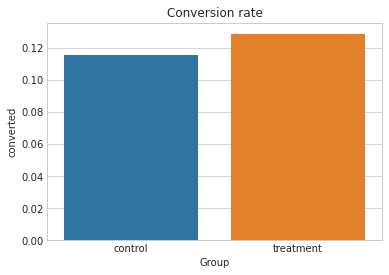

In [16]:
plt.figure()

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.title('Conversion rate')
plt.xlabel('Group')

In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
if pval < 0.05:
    print('Reject null hypothesis: there is a significant difference between the proportions')
else:
    print('It was not possible to reject the null hypothesis, there is no reason to consider the proportions different')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.01
p-value: 0.044
Reject null hypothesis: there is a significant difference between the proportions
95% Confidence interval for control group: [0.106, 0.125]
95% Confidence interval for treatment group: [0.119, 0.139]


In [44]:
print("Mann-Whitney p-value criterion: {0:.3f}".format(stats.mannwhitneyu(control, treatment, alternative = 'two-sided')[1]))
if pval < 0.05:
    print('Reject null hypothesis: the difference in conversion between the groups control and treatment is statistically significant')
else:
    print('It was not possible to reject the null hypothesis,  the difference in conversion between the groups control and treatment is statistically insignificant')

print("Relative increase in Group treatment conversion: {0:.3f}".format(treatment.mean() / control.mean() - 1))

Mann-Whitney p-value criterion: 0.232
Reject null hypothesis: the difference in conversion between the groups control and treatment is statistically significant
Relative increase in Group treatment conversion: -0.012


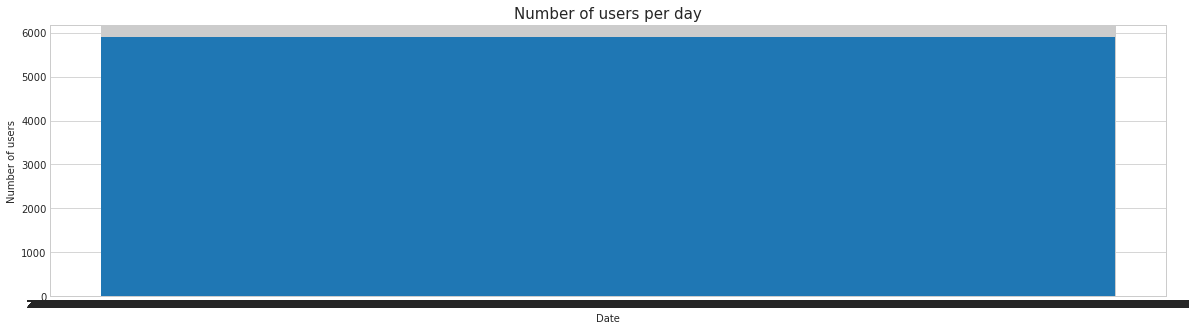

In [8]:
plt.figure(figsize = (20,5))
plt.title('Number of users per day', size = 15)
plt.hist(df['timestamp'], bins = 50)
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.show()

In [9]:
df['timestamp'].describe(datetime_is_numeric=True)

count                         294478
unique                        294478
top       2017-01-21 22:11:48.556739
freq                               1
Name: timestamp, dtype: object

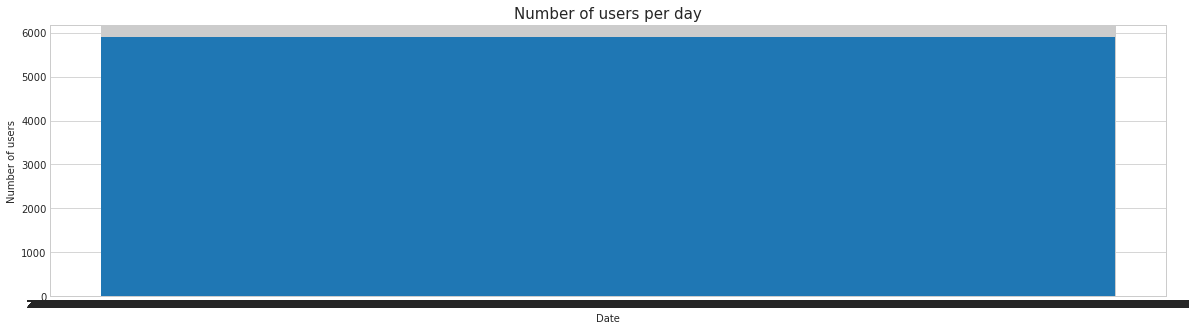

In [10]:
plt.figure(figsize = (20,5))
plt.title('Number of users per day', size = 15)
plt.hist(df['timestamp'], bins = 50)
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.show()